# Make a minimalist movie showing tip trajectories
Tim Tyree<br>
11.16.2020

In [1]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import skimage as sk
from skimage import measure, filters

from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
# width = 512
# height = 512
# channel_no = 3

# #load the libraries
from lib import *
# from lib.measure._find_tips_pbc_cy import lookup_segments
# from lib.measure._find_tips_kernel import *
# from lib.measure._find_tips_kernel_cy import find_intersections
#use cuda via numba
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from numba.typed import List
# from lib.contours_to_tips import *
import shutil
from lib.measure.comp_tips_safely import get_comp_tips
from lib.viewer.DomainPlot import SaveTipsAndColoredContours

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [2]:
#DONE: see if the LR one step method is already cuda accelerated. it's not and shan't
#TODO: get the plotter to be functional 
#TODO: copy the highly successfull method from bgmc over here

In [3]:
# from lib.controller.one_step_splitting_cuda_kernels import get_forward_integrate_kernel

In [4]:
# forward_integrate_kernel=get_forward_integrate_kernel(nb_dir,dt,width,height,ds,stream,diffCoef=0.001,Cm=1.)
# forward_integrate_kernel(txt,txt_Istim, num_steps)

# scratchwerk


In [5]:
# #TODO(later): plot these tips with their u's and v's
# # Display the image and plot all pbc contours found properly!
# def save_plot_as_png(img, dimgdt, x_values, y_values, c_values, n_tips, V_threshold, t, save_folder, frameno, 
#     save = True, inch = 6, **kwargs):
#     ''''''
#     fig, ax = plt.subplots(figsize=(inch,inch))

#     #appears to work     contours1 = find_contours(img,    level = 0.5)
#     contours1 = find_contours(img,    level = V_threshold)
#     contours2 = find_contours(dimgdt, level = 0.0)

#     # ax.imshow(img, cmap=plt.cm.gray)
#     ax.imshow(dimgdt, cmap=plt.cm.gray)
#     # ax.imshow(dimgdt*img, cmap=plt.cm.gray)


#     plot_contours_pbc(contours1, ax, linewidth=2, min_num_vertices=6, linestyle='-', alpha=0.5, color='blue')
#     plot_contours_pbc(contours2, ax, linewidth=2, min_num_vertices=6, linestyle='--', alpha=0.5, color='orange')

#     #plot spiral tips. color inner spiral tip by slow variable
#     ax.scatter(x=x_values, y=y_values, s=270, c=1+0.*c_values, marker='*', zorder=3, alpha=1., vmin=0,vmax=1)
#     ax.scatter(x=x_values, y=y_values, s=45, c=c_values, marker='*', zorder=3, alpha=1., vmin=0,vmax=1, cmap='Blues')
#     # ax.scatter(x=x_values, y=y_values, s=270, c='yellow', marker='*', zorder=3, alpha=1.)
#     # ax.scatter(x=x_values, y=y_values, s=45, c='blue', marker='*', zorder=3, alpha=1.)

#     ax.text(.0,.95,f"t = {t*10**3:.2} s",
#             horizontalalignment='left',color='white',fontsize=16,
#             transform=ax.transAxes)
#     ax.text(.0,.9,f"Num. of Tips  = {n_tips}",
#             horizontalalignment='left',color='white',fontsize=16,
#             transform=ax.transAxes)
#     ax.text(.5,.01,f"Area = {25}cm^2, V. Threshold = {V_threshold}",
#             horizontalalignment='center',color='white',fontsize=16,
#             transform=ax.transAxes)

#     # ax.set_title(f"Area ={25}cm^2, V. Threshold ={V_threshold}, Num. Tips ={n_tips}", color='blue', loc='left',pad=0)
#     ax.axis([0,200,0,200])
# #     ax.axis('image')
#     ax.set_xticks([])
#     ax.set_yticks([])

#     if not save:
#         plt.show()
#     else:
#         os.chdir(save_folder)
#         save_fn = f"img{frameno:07d}.png"
#         frameno += 1
# #         plt.tight_layout()
#         plt.savefig(save_fn,dpi=720/inch, bbox_inches='tight',pad_inches=0);
#         plt.close();
#         #     print(f'figure saved in {save_fn}.')
#         #     plt.savefig('example_parameterless_tip_detection_t_600.png')
#     return frameno

In [6]:
# #import a texture
# # ## practical test case for fast tip detection kernel
# # file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-out/ic_200x200.120.32.npz'
# # txt = load_buffer(file)
# # t   = 0. #ms

# # # #load ^that loaded initial after 20000 steps = 500 ms at time_steps of size 0.025
# # file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_txt.npz'
# # txt  = load_buffer(file)
# # t   = 500 #ms

# # #load a mesh from Luo-Rudy that is near termination
# txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_900.0.npz'
# t=900.
# txt=load_buffer(txt_fn)
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)



# # #define tip detection routine parameters
# # V_threshold = 0.4
# # decimals=10
# # theta_threshold = 0.
# # level1 = V_threshold
# # level2 = 0.0
# # h    = 0.025 #ms

# #define tip detection routine parameters
# V_threshold = -40
# decimals=10
# theta_threshold = 0.
# level1 = V_threshold
# level2 = 0.0
# h    = 0.025#0.0010 #ms
# dt=h
# ds=5#cm
# zero_txt = txt.copy()*0.
# width, height = txt.shape[:2]

# t_list = []
# n_list = []   
# dict_lst = []

In [7]:
# # get_one_step at this dt
# __, arr39, one_step = get_one_step_explicit_synchronous_splitting(
#     nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=0.001,Cm=1.0)

### scratchwerk

In [8]:
# # tmax = 25#30000#6000#3025.600-2*h# 886.6-h#6000#600#510#600#505.225# #ms
# num_steps = 1#int(np.around((tmax-t)/h))
# tmax = h*num_steps+t
# print(tmax)
# step_count = 0
# while t<tmax:
#     #TODO: insert functionality for saving every n frames

# #     #measure system with cython
# #     #compute as discrete flow map dtxt_dt
# #     dtxt_dt = zero_txt.copy()
# #     get_time_step(txt, dtxt_dt)

# #     #compute the images to find isosurfaces of
# #     img    = txt[...,0]
# #     dimgdt = dtxt_dt[...,0]

#     # find_intersections
#     retval = find_intersections(img,dimgdt,level1,level2,theta_threshold=theta_threshold)
#     lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = retval
#     x_values = np.array(lst_values_x)
#     y_values = np.array(lst_values_y)
#     # EP states given by bilinear interpolation with periodic boundary conditions
#     v_lst, f_lst, s_lst = interpolate_states(x_values,y_values,width,height,txt)
#     dvdt_lst, dfdt_lst, dsdt_lst = interpolate_states(x_values,y_values,width,height,dtxt_dt)

#     n_tips = x_values.size
#     dict_out = {
#         't': float(t),
#         'n': int(n_tips),
#         'x': tuple(lst_values_x),
#         'y': tuple(lst_values_y),
#         'theta': tuple(lst_values_theta),
#         'grad_ux': tuple(lst_values_grad_ux),
#         'grad_uy': tuple(lst_values_grad_uy),
#         'grad_vx': tuple(lst_values_grad_vx),
#         'grad_vy': tuple(lst_values_grad_vy),
#         'v':v_lst,
#         'f':f_lst,
#         's':s_lst,
#         'dvdt':dvdt_lst,
#         'dfdt':dfdt_lst,
#         'dsdt':dsdt_lst,
#     }
#     dict_lst.append(dict_out)
    
#     #record data for current time
#     t_list.append(t)
#     n_list.append(n_tips)

#     #forward Euler integration in time
#     txt += h*dtxt_dt
#     t   += h
#     step_count += 1
    
#     #progress bar that updates after each measurement
#     printProgressBar(step_count, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
# beep(1)
# print(f"\nthe current tip number is {n_tips}.")

In [9]:
# #save the state of the system
# c_values = np.array(dfdt_lst)
# # c_values = np.array(s_lst)
# frameno = save_plot_as_png(img, dimgdt, x_values, y_values, c_values, n_tips, V_threshold, t, save_folder, frameno, 
#     save = True, inch = 6)

In [10]:
# #not used in save_figure_as_png
# # def get_time_step(frameno,t,t_unit_string="s"):
# #     return f"frame={frameno}"
# #     return f"t = {t*10**3:.2} "+t_unit_string

# def get_message(ntips):
#     return f"Num. of Tips  = {ntips}"

# #TODO(later): plot these tips with their u's and v's
# # Display the image and plot all pbc contours found properly!
# def save_figure_as_png(fig,ax,save_folder,save_fn,time_step,inch = 6, **kwargs):
#     '''
#     Example Usage:
    
#     '''
#     ax.text(.0,.95,time_step,
#             horizontalalignment='left',color='white',fontsize=16,
#             transform=ax.transAxes)
#     ax.text(.0,.9,message,
#             horizontalalignment='left',color='white',fontsize=16,
#             transform=ax.transAxes)
# #     ax.text(.5,.01,f"Area = {25}cm^2, V. Threshold = {V_threshold}",
# #             horizontalalignment='center',color='white',fontsize=16,
# #             transform=ax.transAxes)
#     os.chdir(save_folder)
#     save_fn = f"img{frameno:07d}.png"
#     frameno += 1
# #         plt.tight_layout()
#     fig.savefig(save_fn,dpi=720/inch, bbox_inches='tight',pad_inches=0);
#     plt.close();
#     return os.path.abspath(save_fn)

# # def plot_system(img,dimgdt,V_threshold=-40):
# # #     #visually verify system
# # #     img=inVc[...,0]
# # #     dimgdt=dVcdt[...,0]
# #     # compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
# #     # dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
# #     #     print(f"{ntips} tips are present at time t={int(t_prev)}.")
# #     fig = ShowDomain(img,dimgdt,x_values,y_values,0.*x_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
# #                      area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,txt.shape[0],0,txt.shape[1]])
# #     ax_list = fig.axes
# #     return fig

In [11]:
# #TODO: add support for getting intersection between frames separated by at least two milliseconds

# tmax = 300000#30000#6000#3025.600-2*h# 886.6-h#6000#600#510#600#505.225# #ms
# num_steps = int(np.around((tmax-t)/h))
# tmax = h*num_steps+t
# # print(tmax)
# n_tips=1
# step_count = 0
# while (t<tmax) & (n_tips > 0):
#     if step_count%save_every_n_frames != 0:
#         #forward Euler integration in time
#         time_step(txt, h, zero_txt)
#     else:
#         #measure system with cython
#         #compute as discrete flow map dtxt_dt
#         dtxt_dt = zero_txt.copy()
#         get_time_step(txt, dtxt_dt)

#         #compute the images to find isosurfaces of
#         img    = txt[...,0]
#         dimgdt = dtxt_dt[...,0]

#         # find_intersections
#         retval = find_intersections(img,dimgdt,level1,level2,theta_threshold=theta_threshold)
#         lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = retval
#         x_values = np.array(lst_values_x)
#         y_values = np.array(lst_values_y)
#         # EP states given by bilinear interpolation with periodic boundary conditions
#         v_lst, f_lst, s_lst = interpolate_states(x_values,y_values,width,height,txt)
#         dvdt_lst, dfdt_lst, dsdt_lst = interpolate_states(x_values,y_values,width,height,dtxt_dt)



#         n_tips = x_values.size
#         dict_out = {
#             't': float(t),
#             'n': int(n_tips),
#             'x': tuple(lst_values_x),
#             'y': tuple(lst_values_y),
#             'theta': tuple(lst_values_theta),
#             'grad_ux': tuple(lst_values_grad_ux),
#             'grad_uy': tuple(lst_values_grad_uy),
#             'grad_vx': tuple(lst_values_grad_vx),
#             'grad_vy': tuple(lst_values_grad_vy),
#             'v':v_lst,
#             'f':f_lst,
#             's':s_lst,
#             'dvdt':dvdt_lst,
#             'dfdt':dfdt_lst,
#             'dsdt':dsdt_lst,
#         }
#         dict_lst.append(dict_out)

#         #record data for current time
#         t_list.append(t)
#         n_list.append(n_tips)

#         #save the state of the system as a png
#         c_values = np.array(dfdt_lst)#s_lst)
#         frameno = save_plot_as_png(img, dimgdt, x_values, y_values, c_values, n_tips, V_threshold, t, save_folder, frameno, 
#                                    save = True, inch = 6)
#         #progress bar that updates after each measurement
#         printProgressBar(step_count, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)

#         #forward Euler integration in time
#         txt += h*dtxt_dt
#     t   += h
#     step_count += 1
    
# beep(3)
# print(f"\nthe current tip number is {n_tips}.")

In [12]:
#TODO: make a *.mov of ^this
#TODO(later): compute the trajectories of spiral tips.
#TODO(later): color tips by their particle number.
#TODO(later): make a *.mov of ^this
#TODO(later): does ^this look reasonable

In [13]:
# save_plot_as_png(img, dimgdt, x_values, y_values, c_values, n_tips, V_threshold, t, save_folder, frameno, 
#                                    save = True, inch = 6)

In [14]:
# #TODO: time step forward 25ms
# #TODO: print dV/dt to file

# contour_lst = split_contour_into_contiguous(contours1[0])
# ct = contour_lst[0]
# print(len(contour_lst))

In [15]:
# min_num_vertices = 3
# pop_until_long_enough(lst_lst=contour_lst,min_length=min_num_vertices)
# print(len(contour_lst))

### TODO(later): add background music from the public domain

- TODO: integrate some integral measure of string curvature between the "high"-halves of the contour2 family of $dV/dt=0$. __I observe that tips move in the direction their nonlocal string dictates.

In [16]:
#TODO: download an audio track to put into the background of the movie before the prepending intro.MTS
# !youtube-dl https://youtu.be/O2KUTa6P6lM -pxl_fmt 720hd -o tmp.mka
# !youtube-dl https://www.youtube.com/watch?v=O2KUTa6P6lM&ab_channel=ThePochaccos

# DONE: make a miminalize movie of the LR model

In [43]:
def save_system_as_png(img,dimgdt,x_values,y_values,c_values,V_threshold,
            frameno,t,
            save_folder,
            save_fn):
    #visually verify system
    # compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
    # dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
    # print(f"{ntips} tips are present at time t={int(t_prev)}.")
    fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,
                     fontsize=16,vmin_img=-85.,vmax_img=35.,area=25,
                     frameno=frameno,
                     save_fn=save_fn,
                     save_folder=save_folder,
                     save=True,
                     annotating=True,
                     axis=[0,img.shape[0],0,img.shape[1]],cmap='bone')
    return save_fn

In [44]:
# # find_intersections
# retval = find_intersections(img,dimgdt,level1,level2,theta_threshold=theta_threshold)
# lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = retval
# x_values = np.array(lst_values_x)
# y_values = np.array(lst_values_y)

In [45]:
# jump_threshold=width/2
# size_threshold=0
# level1=V_threshold
# level2=V_threshold
# #compute spiral tip location and topological number
# contours_a = find_contours(img,        level = level1)
# contours_b = find_contours(img_prev,     level = level2)
# s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold,size_threshold)
# dict_topo={'x':x_lst,'y':y_lst,'s1':s1_lst,'s2':s2_lst, 't':t}
# print(dict_topo)

In [46]:
#initialize file system for movie storing
# min_time_between_samples = 2 #milliseconds
# frameno = 1
# dt=0.01
# save_every_n_frames = int(min_time_between_samples/dt)
dump_cache=True

os.chdir(nb_dir)
save_folder = os.path.join(nb_dir,f'Figures/mov')#c_{"test"}_V_{V_threshold}')
# save_folder_name = f'frame_every_{min_time_between_samples}_ms'
# save_folder = os.path.join(base_folder,save_folder_name)


#dump save_folder if it already exists
if os.path.exists(save_folder) and dump_cache:
    shutil.rmtree(save_folder)
    print(f"dumped cache at {save_folder}")

#create a save_folder if it doesn't already exist
# if not os.path.exists(base_folder):
#     os.mkdir(base_folder)
#     print(f"created save folder at {base_folder}")
# os.chdir(base_folder)
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    print(f"created save folder at {save_folder}")
os.chdir(save_folder)

dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
created save folder at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov


In [47]:
# ic_fn=search_for_file()
# ic_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/test_data/ic008.33_t_750.0.npz'
# t=750

In [48]:
save_folder=f'{nb_dir}/Figures/mov'
ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-out/ic008.33.npz"
t=0

txt=load_buffer(ic_fn)
ds=5.
frameno=1
# txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
V_threshold=-40
dt=0.1 #supports really long termination time...
diffCoef=0.001#0.0005
Cm=1.0
# comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=V_threshold)
# get_one_step at this dt
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=diffCoef,Cm=Cm)
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)


In [49]:
#try to fix the wobble motion by increasing the time between img and img_prev
DT=4 #??
# DT=2 #supported odd numbers of spiral tips briefly
# DT=16 #tips far from apparent tips
#DT=8.#wobbeled
nsteps_per_DT=int(DT/dt)

In [50]:
#comp img_prev example
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
#integrate to t=100 milliseconds
while t<100:
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
img_prev=inVc[...,0].copy()
for n in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt).copy()
img=inVc[...,0].copy();#dimgdt=dVcdt[...,0]

In [51]:
jump_threshold=width/2
size_threshold=0
level1=V_threshold
level2=V_threshold
#compute spiral tip location and topological number
contours_a = find_contours(img,        level = level1)
contours_b = find_contours(img_prev,     level = level2)
s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold,size_threshold)

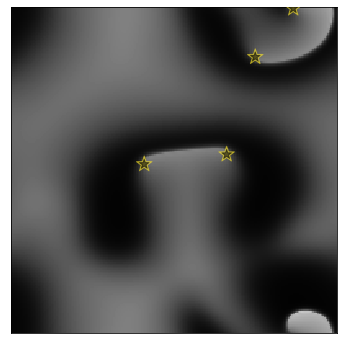

In [52]:
x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values

retval=ShowDomain(img,img_prev,x_values,y_values,c_values,V_threshold,t,inch=6,
                     fontsize=16,vmin_img=-85.,vmax_img=35.,area=25,
                     frameno=frameno,
                     save_fn=None,
                     save_folder=None,
                     save=False,
                     annotating=False,
                     axis=[0,img.shape[0],0,img.shape[1]], cmap='bone');

In [53]:
DT_fps=1#ms between frames
save_every_n_frames=int(DT_fps/dt)#20  #sets the overall frame rate
ntips=1
# while there are tips,
img_item_lst=[]
tfinal=9e9
tnaught=-9e9
while (ntips>0) or (t<tfinal):
    # =stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt).copy()
    #compute tips
    #     inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
    img=inVc[...,0].copy()#;dimgdt=dVcdt[...,0]
    img_item_lst.append((t,img))
    
    #recall img_prev, which is voltage at a time DT earlier
    t_a,img_prev=img_item_lst[0]
    DT_img_item_lst=t-t_a
    if DT_img_item_lst>=DT:
        img_item_lst.pop(0)

        #compute spiral tip location and topological number
        contours_a = find_contours(img,        level = level1)
        contours_b = find_contours(img_prev,     level = level2)
        s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold,size_threshold)
        ntips=len(x_lst)
        x_values=np.array(x_lst)
        y_values=np.array(y_lst)
        c_values=0.*x_values
        #t_prev=t;#txt_prev=txt.copy();
        frameno+=1
        
        #     save png
        if tnaught==-9e9:
            tnaught=t
        save_system_as_png(img,img_prev,x_values,y_values,c_values,V_threshold,
                frameno,t-tnaught,
                save_folder=save_folder,
                save_fn=None)
        print(f"ntips={ntips}, time={t:.1f} ms.", end='\r')

    for j in range(save_every_n_frames):
        #     integrate forward by one_step
        one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
        t+=dt
        
    if (ntips==0) and (tfinal==9e9):
        tfinal=t+100
beep(5)

0

In [54]:
#concatenate the folder of png files to a video
os.chdir(f"{nb_dir}/../vid/src")
!./concat_folder_png.sh

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=-1.0 Lsize=      47kB time=00:00:04.01 bitrate=  95.8kbits/s speed=9.13x    
video:37kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 23.787844%
[libx264 @ 0x55d3f633d200] frame I:1     Avg QP:22.50  size:   208
[libx264 @ 0x55d3f633d200] frame P:61    Avg QP: 5.44  size:   436
[libx264 @ 0x55d3f633d200] frame B:178   Avg QP: 4.22  size:    58
[libx264 @ 0x55d3f633d200] consecutive B-frames:  0.8%  0.8%  0.0% 98.3%
[libx264 @ 0x55d3f633d200] mb I  I16..4: 100.0%  0.0%  0.0%
[libx264 @ 0x55d3f633d200] mb P  I16..4:  0.0%  0.0%  0.0%  P16..4:  0.7%  0.1%  0.1%  0.0%  0.0%    skip:99.1%
[libx264 @ 0x55d3f633d200] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  0.4%  0.0%  0.0%  direct: 0.0%  skip:99.6%  L0:51.7% L1:48.2% BI: 0.2%
[libx264 @ 0x55d3f633d200] final ratefactor: -2.73
[libx264 @ 0x55d3f633d200] 8x8 transform intra:1.5% inter:30.3%
[libx264 @ 0x55d3f633d200] coded y,uvDC,uvAC intra: 1.0% 0.0% 0.0% inter: 0.1% 0.0% 0.0%
[libx264 @ 0

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

In [55]:
#rename that video reasonably
vidname='lr_'+os.path.basename(ic_fn)[:-4]+f'_DT_{DT}.mov'
os.chdir(f"{nb_dir}/../vid/mov")
os.rename('out.mov',vidname)
print(f"renamed video to {vidname}")

renamed video to lr_ic008.33_DT_4.mov


In [57]:
os.path.abspath(vidname)

'/home/timothytyree/Documents/GitHub/care/vid/mov/lr_ic008.33_DT_4.mov'

In [56]:
beep(7)

0

# DONT: analyze pdict

In [31]:
# pl=pdict.get_alive_particles()
# pl

NameError: name 'pdict' is not defined

In [ ]:
# # plot sigma_max of the lesser_arclen versus time for all particles, centering about their last recorded time
# fontsize=18
# saving=True
# savefig_folder=f"{nb_dir}/Figures"
# savefig_fn=f"arclen-versus-ttdeath.png"
# figsize=(6,5)
# fig,ax=plt.subplots(figsize=figsize)

# pid_lst=list(pdict.keys())
# pid_lst=pdict.get_alive_particles()

# # pid_lst=pdict.get_alive_particles()
# for pid in pid_lst[:1]:
#     #extract values
#     sigma_max_values=np.array(pdict[pid]['greater_arclen'])
#     sigma_max_values_other=np.array(pdict[pid]['lesser_arclen'])
#     t_values=np.array(pdict[pid]['t'])
#     t_until_death_values=t_values[-1]-t_values
#     x_values=t_until_death_values
#     y_values=sigma_max_values*5/img.shape[0]
#     y_values_other=sigma_max_values_other*5/img.shape[0]
    
#     #plot values
#     ax.scatter(x_values,y_values,alpha=0.2)
#     ax.scatter(x_values,y_values_other,alpha=0.2)
# #format
# ax.set_xlim([8e-3,2e1])
# ax.set_ylim([1e-2,10])
# ax.set_xlabel('time until death (ms)', fontsize=fontsize)
# ax.set_ylabel('arclength of\nactivation front (cm)', fontsize=fontsize)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.set_xscale('log')
# ax.set_yscale('log')
# if not saving: 
#     plt.show() 
# else:
#     plt.tight_layout()
#     os.chdir(savefig_folder)
#     plt.savefig(savefig_fn, dpi=300)
#     print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [ ]:
# len(dict_topo['x'])

# DONT: make movie highlighting curvature

In [ ]:
# # #load a mesh from Luo-Rudy
# # ic_fn=search_for_file()
# try:
#     ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-out/ic008.33.npz"
#     txt=load_buffer(ic_fn)
#     t=0
# except FileNotFoundError as e:
#     ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-in/ic008.33.npz"
#     txt=load_buffer(ic_fn)
#     t=0   
    
# save_folder=f"{nb_dir}/Figures/mov"    
# ds=5.
# frameno=0
# DT=2.
# dt=0.01
# nsteps_per_DT=int(DT/dt)
# save_every_n_frames=50

In [ ]:
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
# width,height=txt.shape[:2]
# V_threshold=-50;dt=0.01

# # comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=0.)
# # get_one_step at this dt
# __, arr39, one_step = get_one_step_explicit_synchronous_splitting(
#     nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=0.0005,Cm=1.0)
# # comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)
# txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

In [ ]:
# img_prev=txt[...,0].copy()
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
# for n in range(nsteps_per_DT):
#     one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
#     t+=dt
# txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
# img=inVc[...,0]
# dimgdt=dVcdt[...,0]

# comp_tips=get_comp_tips(width,height,V_threshold)
# dict_tips=comp_tips(img,img_prev,dimgdt,t,txt)
# pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)#, **kwargs)

# if not os.path.exists(save_folder):
#     os.mkdir(save_folder)

In [ ]:
# # while there are still tips,
# img_item_lst=[]
# ntips=len(dict_tips['x'])
# while ntips>0:
#     txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt).copy()
#     #compute images
#     img=inVc[...,0].copy()#;dimgdt=dVcdt[...,0]
#     img_item_lst.append((t,img))
#     #recall img_prev, which is voltage at a time DT earlier
#     t_a,img_prev=img_item_lst[0]
#     DT_img_item_lst=t-t_a
#     if DT_img_item_lst>=DT:
#         #record tips
#         img_item_lst.pop(0)
#         dict_tips=comp_tips(img,img_prev,dimgdt, t, txt)
#         ntips=len(dict_tips['x'])
#         if ntips>0:
#             pdict.merge(dict_tips)
#             # t_prev=t;txt_prev=txt.copy();
#         frameno=SaveTipsAndColoredContours(img,frameno,dict_tips,save_folder=save_folder)#,save_fn=None,vmin_img=-85.,vmax_img=35.,inch=5)
#         print(f"saved ntips={ntips}, time={t:.2f} ms.", end='\r')

#     for j in range(save_every_n_frames):
#         #     integrate forward by one_step
#         one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
#         t+=dt
# #save a few more frames
# nframes_extra=50
# for n in range(nframes_extra):
#     txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt).copy()
#     #compute images
#     img=inVc[...,0].copy()#;dimgdt=dVcdt[...,0]
#     img_item_lst.append((t,img))
#     #recall img_prev, which is voltage at a time DT earlier
#     t_a,img_prev=img_item_lst[0]
#     DT_img_item_lst=t-t_a
#     if DT_img_item_lst>=DT:
#         #record tips
#         img_item_lst.pop(0)
#         dict_tips=comp_tips(img,img_prev,dimgdt, t, txt)
#         ntips=len(dict_tips['x'])
#         frameno=SaveTipsAndColoredContours(img,frameno,dict_tips,save_folder=save_folder)#,save_fn=None,vmin_img=-85.,vmax_img=35.,inch=5)
#     for j in range(save_every_n_frames):
#         #     integrate forward by one_step
#         one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
#         t+=dt
# beep(5)